## 1. Import Modules and Data

In [5]:
from data import mnist_dataloader, cifar10_dataloader
from modules import GAN
import torch
from torch import nn
import config
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
import os
import math
import matplotlib.pyplot as plt
import numpy as np

sample_mnist_dir = os.path.join(config.sample_mnist_dir, "gan")
sample_cifar10_dir = os.path.join(config.sample_cifar10_dir, "gan")

os.makedirs(sample_mnist_dir, exist_ok=True)
os.makedirs(sample_cifar10_dir, exist_ok=True)

config.device

device(type='cuda', index=0)

## 2. Build Model

In [6]:
model = GAN(
    z_dim=config.z_dim,
    output_dim=28 * 28,  # Output size for MNIST (28x28)
    gen_hidden_dims=[128, 256, 512, 1024],
    disc_hidden_dims=[512, 256, 128],
    leaky_relu_slope=config.leaky_relu_slope,
    device=config.device,
)

model2 = GAN(
    z_dim=config.z_dim,
    output_dim=3 * 32 * 32,  # Output size for CIFAR10 (3x32x32)
    gen_hidden_dims=[128, 256, 512, 1024],
    disc_hidden_dims=[512, 256, 128],
    leaky_relu_slope=config.leaky_relu_slope,
    device=config.device,
)

## 3. Train Model
We train models on MNIST dataset and CIFAR10 dataset.

In [8]:
def train(model, dataloader, sample_dir, epoch):
    criterion = nn.BCELoss()
    optim_G = torch.optim.Adam(
        model.generator.parameters(), lr=config.gen_lr, betas=config.betas
    )
    optim_D = torch.optim.Adam(
        model.discriminator.parameters(), lr=config.disc_lr, betas=config.betas
    )
    d_losses = []
    g_losses = []

    for real_images, _ in tqdm(dataloader, desc=f"Training epoch {epoch + 1}"):
        batch_size, shape = real_images.shape[0], tuple(real_images.shape[1:])
        real_images = real_images.view(-1, np.prod(shape)).to(config.device)
        real_labels = torch.ones(batch_size).to(config.device)
        fake_labels = torch.zeros(batch_size).to(config.device)

        # Train Discriminator
        optim_D.zero_grad()
        outputs = model.discriminate(real_images)
        d_loss_real = criterion(outputs, real_labels)

        z = torch.randn(batch_size, config.z_dim).to(config.device)
        fake_images = model.generate(z)
        outputs = model.discriminate(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optim_D.step()

        # Train Generator
        optim_G.zero_grad()
        outputs = model.discriminate(fake_images)
        g_loss = criterion(outputs, real_labels)

        g_loss.backward()
        optim_G.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

    # Save generated images every sample_interval epoch
    if (epoch + 1) % config.sample_interval == 0:
        model.eval()
        with torch.no_grad():
            fake_images = model.generate(
                torch.randn(config.num_samples, config.z_dim, device=config.device)
            ).view(
                -1, *shape
            )  # Generate num_samples images
            save_image(
                fake_images,
                os.path.join(sample_dir, f"generated_images_epoch_{epoch+1}.png"),
                nrow=int(math.sqrt(config.num_samples)),
                normalize=True,
            )
        model.train()

    return sum(d_losses) / len(d_losses), sum(g_losses) / len(g_losses)

In [4]:
print("Train on MNIST dataset...")
for epoch in range(config.epochs):
    avg_d_loss, avg_g_loss = train(model, mnist_dataloader, sample_mnist_dir, epoch)
    print(
        f"Epoch {epoch+1}/{config.epochs} Average Loss D: {avg_d_loss:.4f}, Average Loss G: {avg_g_loss:.4f}"
    )

model.save(os.path.join(config.ckpt_mnist_dir, f"gan.pth"))

Train on MNIST dataset...


Training epoch 1: 100%|██████████| 469/469 [00:14<00:00, 32.96it/s]


Epoch 1/30 Average Loss D: 1.1862, Average Loss G: 1.0416


Training epoch 2: 100%|██████████| 469/469 [00:13<00:00, 33.66it/s]


Epoch 2/30 Average Loss D: 1.1252, Average Loss G: 1.4162


Training epoch 3: 100%|██████████| 469/469 [00:14<00:00, 32.50it/s]


Epoch 3/30 Average Loss D: 1.1981, Average Loss G: 1.3406


Training epoch 4: 100%|██████████| 469/469 [00:14<00:00, 32.07it/s]


Epoch 4/30 Average Loss D: 1.2041, Average Loss G: 1.2585


Training epoch 5: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]


Epoch 5/30 Average Loss D: 1.2193, Average Loss G: 1.1904


Training epoch 6: 100%|██████████| 469/469 [00:14<00:00, 32.21it/s]


Epoch 6/30 Average Loss D: 1.2178, Average Loss G: 1.1344


Training epoch 7: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s]


Epoch 7/30 Average Loss D: 1.2392, Average Loss G: 1.0617


Training epoch 8: 100%|██████████| 469/469 [00:14<00:00, 32.17it/s]


Epoch 8/30 Average Loss D: 1.2211, Average Loss G: 1.0688


Training epoch 9: 100%|██████████| 469/469 [00:14<00:00, 32.21it/s]


Epoch 9/30 Average Loss D: 1.2052, Average Loss G: 1.0753


Training epoch 10: 100%|██████████| 469/469 [00:14<00:00, 32.43it/s]


Epoch 10/30 Average Loss D: 1.2154, Average Loss G: 1.0553


Training epoch 11: 100%|██████████| 469/469 [00:14<00:00, 32.19it/s]


Epoch 11/30 Average Loss D: 1.2213, Average Loss G: 1.0455


Training epoch 12: 100%|██████████| 469/469 [00:14<00:00, 31.87it/s]


Epoch 12/30 Average Loss D: 1.2213, Average Loss G: 1.0434


Training epoch 13: 100%|██████████| 469/469 [00:14<00:00, 31.84it/s]


Epoch 13/30 Average Loss D: 1.2234, Average Loss G: 1.0341


Training epoch 14: 100%|██████████| 469/469 [00:15<00:00, 29.37it/s]


Epoch 14/30 Average Loss D: 1.2322, Average Loss G: 1.0258


Training epoch 15: 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]


Epoch 15/30 Average Loss D: 1.2391, Average Loss G: 1.0248


Training epoch 16: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]


Epoch 16/30 Average Loss D: 1.2471, Average Loss G: 1.0059


Training epoch 17: 100%|██████████| 469/469 [00:16<00:00, 28.86it/s]


Epoch 17/30 Average Loss D: 1.2525, Average Loss G: 0.9988


Training epoch 18: 100%|██████████| 469/469 [00:16<00:00, 29.09it/s]


Epoch 18/30 Average Loss D: 1.2572, Average Loss G: 0.9884


Training epoch 19: 100%|██████████| 469/469 [00:16<00:00, 28.12it/s]


Epoch 19/30 Average Loss D: 1.2599, Average Loss G: 0.9890


Training epoch 20: 100%|██████████| 469/469 [00:16<00:00, 29.03it/s]


Epoch 20/30 Average Loss D: 1.2664, Average Loss G: 0.9758


Training epoch 21: 100%|██████████| 469/469 [00:16<00:00, 28.77it/s]


Epoch 21/30 Average Loss D: 1.2657, Average Loss G: 0.9729


Training epoch 22: 100%|██████████| 469/469 [00:15<00:00, 29.45it/s]


Epoch 22/30 Average Loss D: 1.2688, Average Loss G: 0.9713


Training epoch 23: 100%|██████████| 469/469 [00:16<00:00, 28.79it/s]


Epoch 23/30 Average Loss D: 1.2720, Average Loss G: 0.9621


Training epoch 24: 100%|██████████| 469/469 [00:16<00:00, 28.83it/s]


Epoch 24/30 Average Loss D: 1.2728, Average Loss G: 0.9623


Training epoch 25: 100%|██████████| 469/469 [00:16<00:00, 28.37it/s]


Epoch 25/30 Average Loss D: 1.2755, Average Loss G: 0.9531


Training epoch 26: 100%|██████████| 469/469 [00:16<00:00, 28.79it/s]


Epoch 26/30 Average Loss D: 1.2771, Average Loss G: 0.9507


Training epoch 27: 100%|██████████| 469/469 [00:16<00:00, 28.67it/s]


Epoch 27/30 Average Loss D: 1.2800, Average Loss G: 0.9470


Training epoch 28: 100%|██████████| 469/469 [00:16<00:00, 29.19it/s]


Epoch 28/30 Average Loss D: 1.2796, Average Loss G: 0.9419


Training epoch 29: 100%|██████████| 469/469 [00:16<00:00, 28.90it/s]


Epoch 29/30 Average Loss D: 1.2811, Average Loss G: 0.9399


Training epoch 30: 100%|██████████| 469/469 [00:15<00:00, 29.31it/s]

Epoch 30/30 Average Loss D: 1.2810, Average Loss G: 0.9426


In [9]:
print("Train on CIFAR10 dataset...")
for epoch in range(config.epochs):
    avg_d_loss, avg_g_loss = train(model2, cifar10_dataloader, sample_cifar10_dir, epoch)
    print(
        f"Epoch {epoch+1}/{config.epochs} Average Loss D: {avg_d_loss:.4f}, Average Loss G: {avg_g_loss:.4f}"
    )

model2.save(os.path.join(config.ckpt_cifar10_dir, f"gan.pth"))

Train on CIFAR10 dataset...


Training epoch 1: 100%|██████████| 391/391 [00:16<00:00, 24.40it/s]


Epoch 1/30 Average Loss D: 0.8249, Average Loss G: 2.4184


Training epoch 2: 100%|██████████| 391/391 [00:15<00:00, 25.79it/s]


Epoch 2/30 Average Loss D: 0.9293, Average Loss G: 2.6505


Training epoch 3: 100%|██████████| 391/391 [00:15<00:00, 25.44it/s]


Epoch 3/30 Average Loss D: 1.0697, Average Loss G: 2.2920


Training epoch 4: 100%|██████████| 391/391 [00:15<00:00, 25.24it/s]


Epoch 4/30 Average Loss D: 1.1007, Average Loss G: 2.0703


Training epoch 5: 100%|██████████| 391/391 [00:15<00:00, 25.16it/s]


Epoch 5/30 Average Loss D: 1.1194, Average Loss G: 1.9396


Training epoch 6: 100%|██████████| 391/391 [00:15<00:00, 25.24it/s]


Epoch 6/30 Average Loss D: 1.1163, Average Loss G: 1.8685


Training epoch 7: 100%|██████████| 391/391 [00:15<00:00, 25.19it/s]


Epoch 7/30 Average Loss D: 1.1687, Average Loss G: 1.6572


Training epoch 8: 100%|██████████| 391/391 [00:15<00:00, 24.71it/s]


Epoch 8/30 Average Loss D: 1.1891, Average Loss G: 1.5506


Training epoch 9: 100%|██████████| 391/391 [00:15<00:00, 24.94it/s]


Epoch 9/30 Average Loss D: 1.2055, Average Loss G: 1.4634


Training epoch 10: 100%|██████████| 391/391 [00:15<00:00, 25.00it/s]


Epoch 10/30 Average Loss D: 1.2106, Average Loss G: 1.4303


Training epoch 11: 100%|██████████| 391/391 [00:15<00:00, 25.33it/s]


Epoch 11/30 Average Loss D: 1.2697, Average Loss G: 1.2349


Training epoch 12: 100%|██████████| 391/391 [00:15<00:00, 25.45it/s]


Epoch 12/30 Average Loss D: 1.2846, Average Loss G: 1.1076


Training epoch 13: 100%|██████████| 391/391 [00:15<00:00, 25.52it/s]


Epoch 13/30 Average Loss D: 1.3046, Average Loss G: 1.0109


Training epoch 14: 100%|██████████| 391/391 [00:15<00:00, 25.24it/s]


Epoch 14/30 Average Loss D: 1.3156, Average Loss G: 0.9563


Training epoch 15: 100%|██████████| 391/391 [00:15<00:00, 25.27it/s]


Epoch 15/30 Average Loss D: 1.3368, Average Loss G: 0.9353


Training epoch 16: 100%|██████████| 391/391 [00:15<00:00, 25.10it/s]


Epoch 16/30 Average Loss D: 1.3235, Average Loss G: 0.9063


Training epoch 17: 100%|██████████| 391/391 [00:15<00:00, 25.15it/s]


Epoch 17/30 Average Loss D: 1.3285, Average Loss G: 0.9174


Training epoch 18: 100%|██████████| 391/391 [00:15<00:00, 25.00it/s]


Epoch 18/30 Average Loss D: 1.3381, Average Loss G: 0.8903


Training epoch 19: 100%|██████████| 391/391 [00:15<00:00, 24.52it/s]


Epoch 19/30 Average Loss D: 1.3446, Average Loss G: 0.8721


Training epoch 20: 100%|██████████| 391/391 [00:15<00:00, 25.07it/s]


Epoch 20/30 Average Loss D: 1.3694, Average Loss G: 0.8296


Training epoch 21: 100%|██████████| 391/391 [00:15<00:00, 25.18it/s]


Epoch 21/30 Average Loss D: 1.3493, Average Loss G: 0.8342


Training epoch 22: 100%|██████████| 391/391 [00:15<00:00, 24.77it/s]


Epoch 22/30 Average Loss D: 1.3568, Average Loss G: 0.8504


Training epoch 23: 100%|██████████| 391/391 [00:15<00:00, 25.04it/s]


Epoch 23/30 Average Loss D: 1.3529, Average Loss G: 0.8483


Training epoch 24: 100%|██████████| 391/391 [00:15<00:00, 25.49it/s]


Epoch 24/30 Average Loss D: 1.3723, Average Loss G: 0.8233


Training epoch 25: 100%|██████████| 391/391 [00:15<00:00, 25.25it/s]


Epoch 25/30 Average Loss D: 1.3584, Average Loss G: 0.8326


Training epoch 26: 100%|██████████| 391/391 [00:15<00:00, 25.32it/s]


Epoch 26/30 Average Loss D: 1.3621, Average Loss G: 0.8285


Training epoch 27: 100%|██████████| 391/391 [00:15<00:00, 24.87it/s]


Epoch 27/30 Average Loss D: 1.3593, Average Loss G: 0.8403


Training epoch 28: 100%|██████████| 391/391 [00:15<00:00, 25.24it/s]


Epoch 28/30 Average Loss D: 1.3740, Average Loss G: 0.8237


Training epoch 29: 100%|██████████| 391/391 [00:15<00:00, 25.13it/s]


Epoch 29/30 Average Loss D: 1.3720, Average Loss G: 0.8034


Training epoch 30: 100%|██████████| 391/391 [00:15<00:00, 25.41it/s]


Epoch 30/30 Average Loss D: 1.3650, Average Loss G: 0.8269


## 4. Sample
Let's compare the differences between real images and fake images.

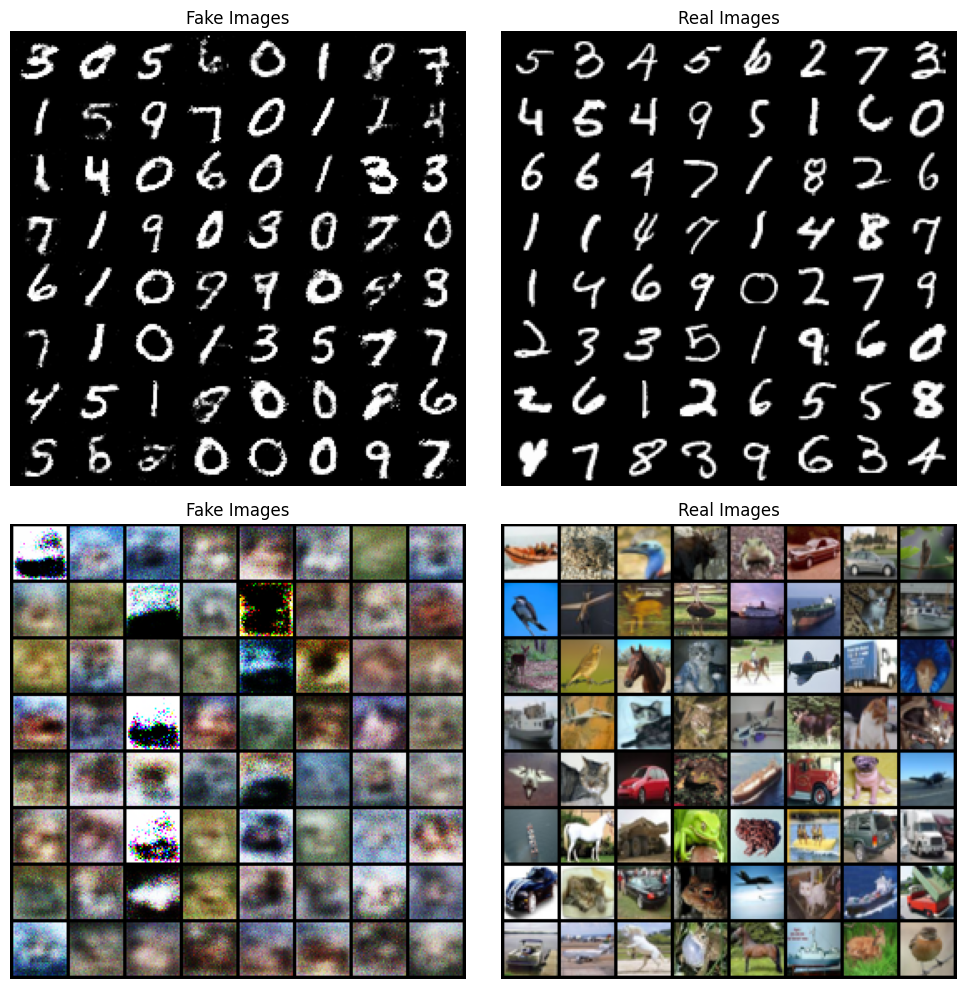

In [11]:
plt.figure(figsize=(10, 10))

def sample_and_compare(model, dataloader, row):
    model.eval()
    real_batch = next(iter(dataloader))
    shape = tuple(real_batch[0].shape[1:])
    fake_images = (
        model.generate(torch.randn(64, config.z_dim, device=config.device))
        .view(-1, *shape)
        .cpu()
    )

    plt.subplot(2, 2, row * 2 - 1)
    plt.imshow(make_grid(fake_images, nrow=8, normalize=True).permute(1, 2, 0))
    plt.axis("off")
    plt.title("Fake Images")

    plt.subplot(2, 2, row * 2)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(
        make_grid(real_batch[0].cpu()[:64], nrow=8, normalize=True).permute(1, 2, 0)
    )


sample_and_compare(model, mnist_dataloader, 1)
sample_and_compare(model2, cifar10_dataloader, 2)
plt.tight_layout()
plt.show()